In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from statsmodels.tsa.arima.model import ARIMA


In [25]:

df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


#### Definition 

Model: ElasticNet
MAPE: 11.58%
MAE: 2594.05
RMSE: 3558.88
R²: 0.6742


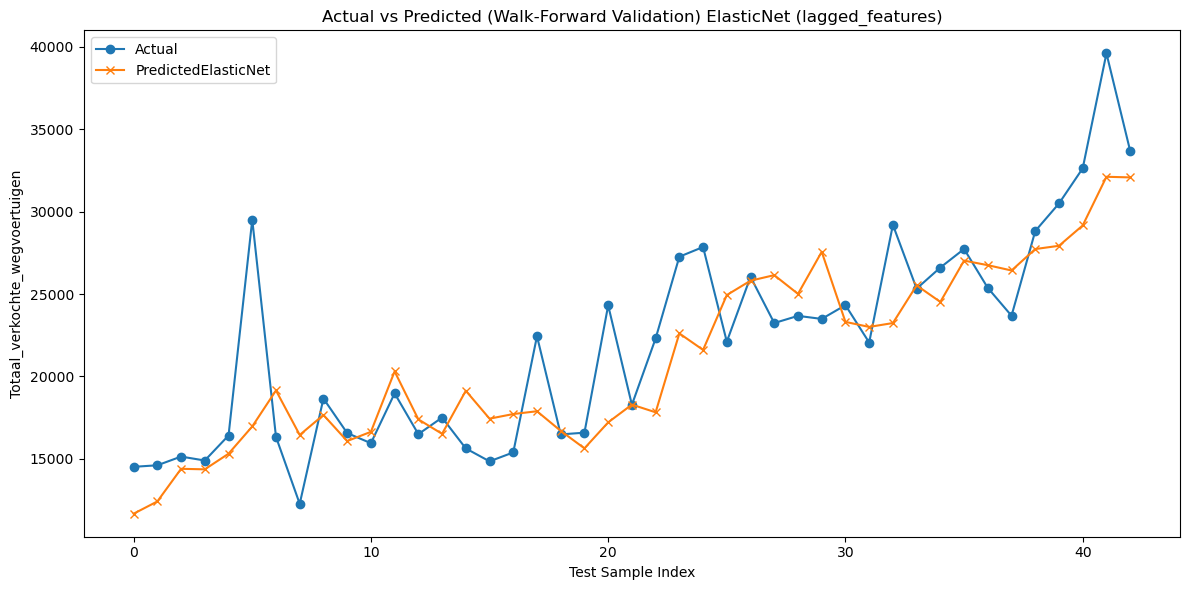

Model: Linear Regression
MAPE: 11.33%
MAE: 2537.26
RMSE: 3483.25
R²: 0.6879


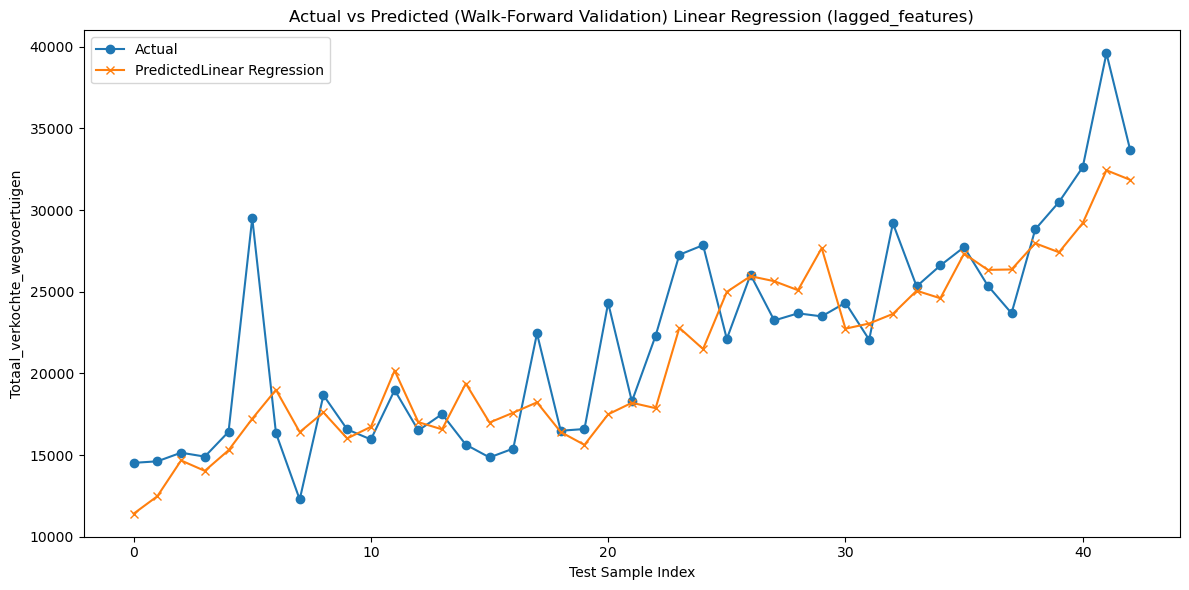

In [59]:
# Only use lagged features for linear regression
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']  # List of lagged features and time features, defined here

# Combine all features (economic, fuel, lagged, etc.)
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',  # Electric/hybrid car features from your dataframe
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',  # Economic indicators from your dataframe
    'Koopbereidheid', 'Grote aankopen',  # More economic indicators from your dataframe
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',  # Fuel price features from your dataframe
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',  # More fuel price features from your dataframe
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'  # Diesel price features from your dataframe
] + lagged_features  # Add the lagged features defined above

# Define a function for walk-forward validation
def walk_forward_validation(df, features, target_col, model, forecast_horizon):
    """
    Perform walk-forward validation using Linear Regression on the given dataframe.
    Returns MAE, RMSE, R2, MAPE, predictions, and actuals.
    """
    X = df[features].values  # Select feature columns from the dataframe and convert to numpy array
    y = df[target_col].values  # Select the target column from the dataframe and convert to numpy array
    initial_train_size = int(len(df) * 0.8)  # Use 80% of data for initial training
    predictions = []  # List to store predictions
    actuals = []  # List to store actual values
    for i in range(initial_train_size, len(df)):  # Loop over each test point after the training set
        X_train, y_train = X[:i], y[:i]  # Use data up to i for training
        X_test, y_test = X[i], y[i]  # Use the i-th data point for testing
        # Zowel bij y_train als y_test de forecast horizon optellen!! (Dutch comment: add forecast horizon to y_train and y_test if needed)
        model.fit(X_train, y_train)  # Fit the model on training data
        y_pred = model.predict(X_test.reshape(1, -1))[0]  # Predict the next value and get the first element
        predictions.append(y_pred)  # Store the prediction
        actuals.append(y_test)  # Store the actual value
    predictions = np.array(predictions)  # Convert predictions list to numpy array
    actuals = np.array(actuals)  # Convert actuals list to numpy array
    mae = mean_absolute_error(actuals, predictions)  # Calculate Mean Absolute Error using sklearn
    mse = mean_squared_error(actuals, predictions)  # Calculate Mean Squared Error using sklearn
    rmse = np.sqrt(mse)  # Calculate Root Mean Squared Error
    r2 = r2_score(actuals, predictions)  # Calculate R2 score using sklearn
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100  # Calculate Mean Absolute Percentage Error
    return mae, rmse, r2, mape, predictions, actuals  # Return all metrics and arrays

# Define a function to plot results
def plot_results(model_name, mae, rmse, r2, mape, predictions, actuals, features):
    print("Model: " + model_name)  # Print the model name
    print(f"MAPE: {mape:.2f}%")  # Print Mean Absolute Percentage Error
    print(f"MAE: {mae:.2f}")  # Print Mean Absolute Error
    print(f"RMSE: {rmse:.2f}")  # Print Root Mean Squared Error
    print(f"R²: {r2:.4f}")  # Print R2 score

    plt.figure(figsize=(12, 6))  # Create a new figure for plotting
    plt.plot(actuals, label='Actual', marker='o')  # Plot actual values
    plt.plot(predictions, label='Predicted'+ model_name, marker='x')  # Plot predicted values
    plt.title('Actual vs Predicted (Walk-Forward Validation) ' + model_name + ' (' + features + ')')  # Set plot title
    plt.xlabel('Test Sample Index')  # Set x-axis label
    plt.ylabel('Totaal_verkochte_wegvoertuigen')  # Set y-axis label
    plt.legend()  # Show legend
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot



# Create model objects using sklearn classes imported earlier
linear_regression_model = LinearRegression()  # Linear Regression model from sklearn
elastic_net_model = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=10000, random_state=42)  # ElasticNet model from sklearn

# Run walk-forward validation for ElasticNet model
mae_en, rmse_en, r2_en, mape_en, predictions_en, actuals_en = walk_forward_validation(
    df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', elastic_net_model, forecast_horizon = 1)  # Use the function defined above with lagged_features

# Run walk-forward validation for Linear Regression model
mae_lr, rmse_lr, r2_lr, mape_lr, predictions_lr, actuals_lr = walk_forward_validation(
    df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', linear_regression_model, forecast_horizon=3)  # Use the function defined above with lagged_features

# Plot results for ElasticNet model
plot_results("ElasticNet", mae_en, rmse_en, r2_en, mape_en, predictions_en, actuals_en, features="lagged_features")  # Use the function defined above

# Plot results for Linear Regression model
plot_results("Linear Regression", mae_lr, rmse_lr, r2_lr, mape_lr, predictions_lr, actuals_lr, features="lagged_features")  # Use the function defined above

Model: ElasticNet
MAPE: 11.58%
MAE: 2594.05
RMSE: 3558.88
R²: 0.6742


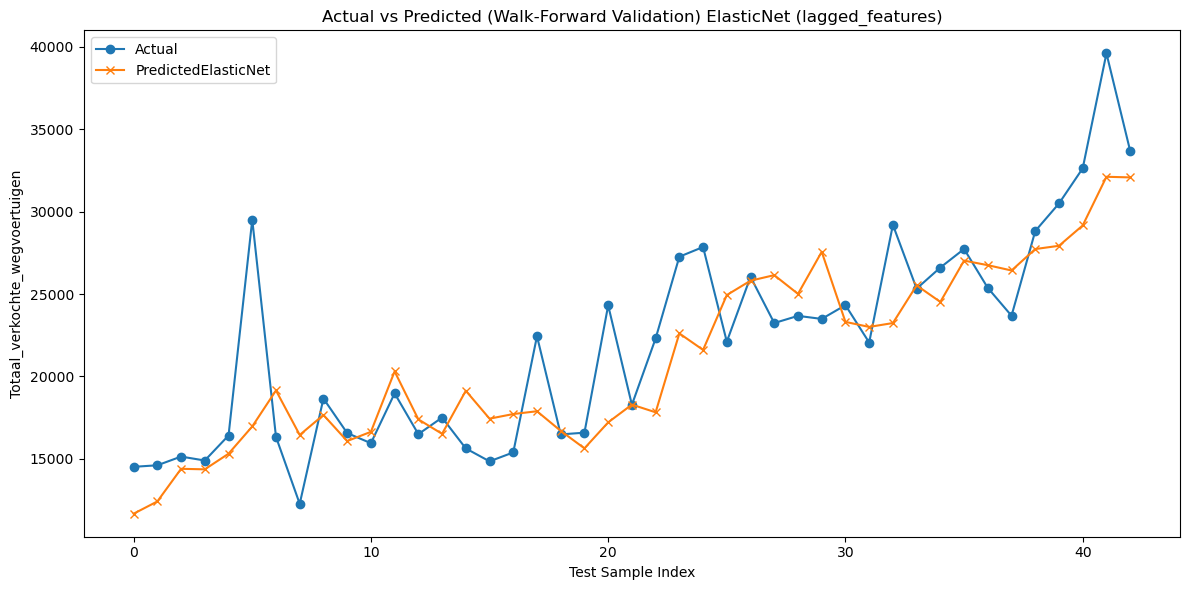

Model: Linear Regression
MAPE: 11.33%
MAE: 2537.26
RMSE: 3483.25
R²: 0.6879


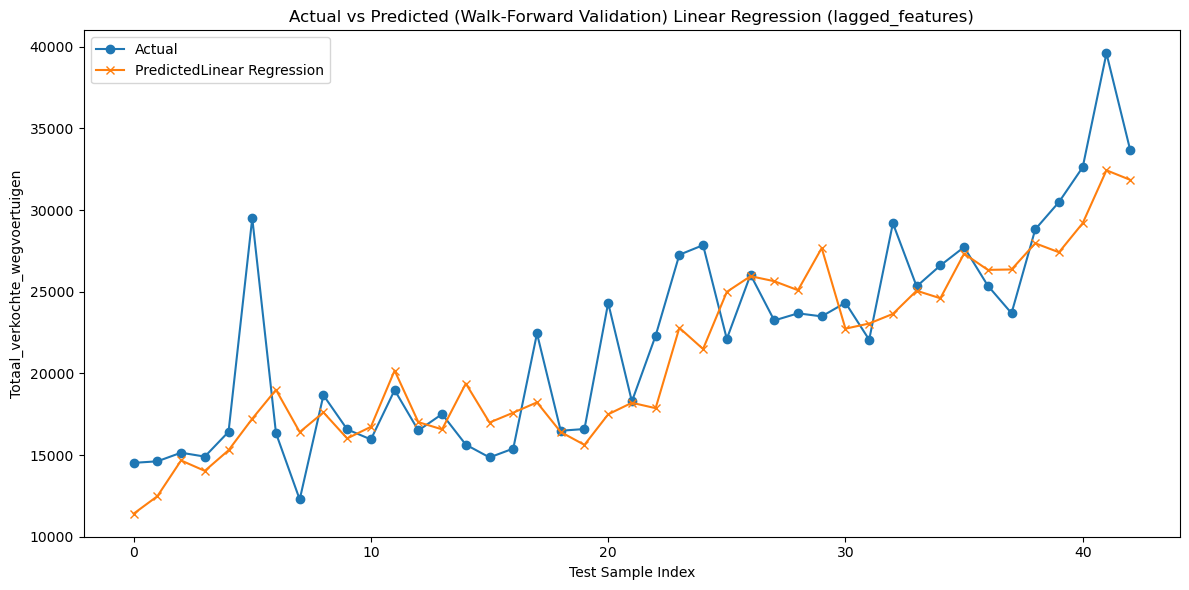

In [58]:

# Create model objects using sklearn classes imported earlier
linear_regression_model = LinearRegression()  # Linear Regression model from sklearn
elastic_net_model = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=10000, random_state=42)  # ElasticNet model from sklearn

# Run walk-forward validation for ElasticNet model
mae_en, rmse_en, r2_en, mape_en, predictions_en, actuals_en = walk_forward_validation(
    df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', elastic_net_model, forecast_horizon = 1)  # Use the function defined above with lagged_features

# Run walk-forward validation for Linear Regression model
mae_lr, rmse_lr, r2_lr, mape_lr, predictions_lr, actuals_lr = walk_forward_validation(
    df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', linear_regression_model, forecast_horizon=3)  # Use the function defined above with lagged_features

# Plot results for ElasticNet model
plot_results("ElasticNet", mae_en, rmse_en, r2_en, mape_en, predictions_en, actuals_en, features="lagged_features")  # Use the function defined above

# Plot results for Linear Regression model
plot_results("Linear Regression", mae_lr, rmse_lr, r2_lr, mape_lr, predictions_lr, actuals_lr, features="lagged_features")  # Use the function defined above

#### Arima

Model: ARIMA(1,0,0)
MAPE: 18.33%
MAE: 4073.39
RMSE: 5233.64
R²: 0.2954


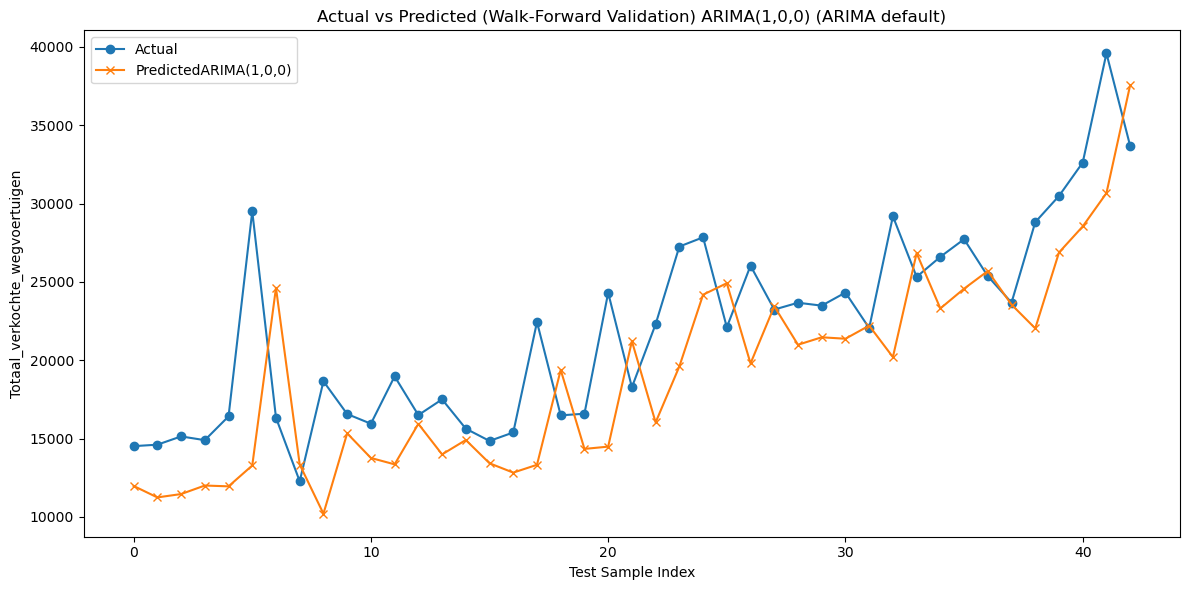

In [49]:
def walk_forward_arima(df, target_col, order=(1,0,0), forecast_horizon=1):
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        train = y[:i]
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=forecast_horizon)[-1]
        predictions.append(y_pred)
        actuals.append(y[i])
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape, predictions, actuals

arima_model= xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1,max_depth=3, random_state=42, eval_metric="mape")


mae_arima, rmse_arima, r2_arima, mape_arima, predictions_arima, actuals_arima = walk_forward_arima(
    df_lagged, 'Totaal_verkochte_wegvoertuigen', order=(1,0,0), forecast_horizon=1
)

plot_results("ARIMA(1,0,0)", mae_arima, rmse_arima, r2_arima, mape_arima, predictions_arima, actuals_arima, features="ARIMA default")


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model

Model: ARIMAX
MAPE: 11.73%
MAE: 2662.72
RMSE: 3665.28
R²: 0.6544


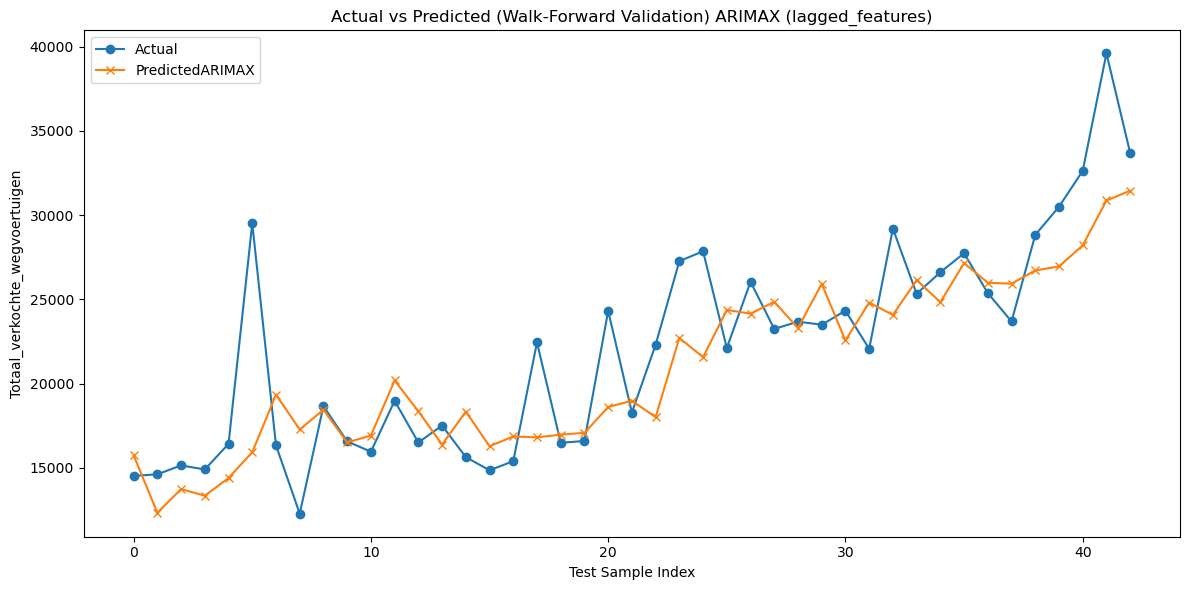

In [51]:
from statsmodels.tsa.arima.model import ARIMA

class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.y_train = None
        self.X_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.model_fit = ARIMA(endog=y, exog=X, order=self.order).fit()

    def predict(self, X):
        forecast = self.model_fit.forecast(steps=1, exog=X.reshape(1, -1))
        return [forecast[0]]


arimax_model = ARIMAXWrapper(order=(3, 1, 2))

mae_arimax, rmse_arimax, r2_arimax, mape_arimax, predictions_arimax, actuals_arimax = walk_forward_validation(
    df_lagged,
    lagged_features,
    'Totaal_verkochte_wegvoertuigen',
    arimax_model,
    forecast_horizon=1
)

plot_results("ARIMAX", mae_arimax, rmse_arimax, r2_arimax, mape_arimax, predictions_arimax, actuals_arimax, features="lagged_features")

### XGBoost

Model: Xgb
MAPE: 11.72%
MAE: 2623.66
RMSE: 3467.32
R²: 0.6907


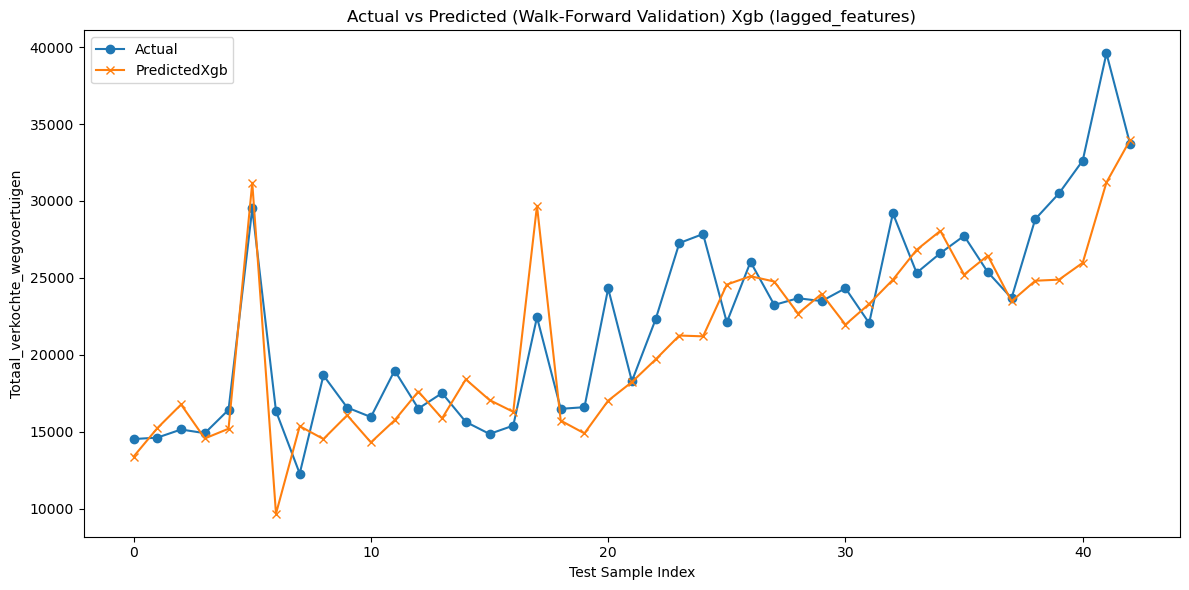

In [44]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1,max_depth=3, random_state=42, eval_metric="mape")



 
mae_xgb, rmse_xgb, r2_xgb, mape_xgb, predictions_xgb, actuals_xgb = walk_forward_validation(df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', xgb_model, forecast_horizon = 1)


 
plot_results("Xgb", mae_xgb, rmse_xgb, r2_xgb, mape_xgb, predictions_xgb, actuals_xgb, features="lagged_features")

 